<a href="https://colab.research.google.com/github/Venu2791/Deep-Vision/blob/master/Assignment%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 10

**Problem Statement:**

* Implement GradCAM on final and penultimate layers of Pre-trained VGG network and make obsevations.
* Further, load a given image and spot the sunglasses (Imagenet already has sunglasses class).





**Importing libraries and modules**
 
We load pre-trained VGG16 model (imagenet weights),import methods: 

* Preprocess_input  - Preprocess the images as per imagenet standards and,
* Decode_predictions - Decode the predictions as per imagenet class 



In [0]:
from keras import backend as K
import time
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(100)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
!pip install -q utils 
from google.colab.patches import cv2_imshow #cv2_imshow : The normal imshow() method of cv2 does not work with google colab notebooks and hence this is a patch for that method


In [0]:
# Loading VGG16 with imagenet weights and print the model summary.
model = VGG16(weights="imagenet")
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Where is CNN looking? - GradCAM:**

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

**Steps for GradCAM:**
*  Load a pre-trained model.
*  Load an image which can be processed by this model.
*  Infer the image and get the topmost class index.
*  Take the output of the final convolutional layer.
*  Compute the gradient of the class output value w.r.t to L feature maps.
*  Pool the gradients over all the axes leaving out the channel dimension.
*   Weigh the output feature map with the computed gradients (+ve).
*   Average the weighted feature maps along channels.
*   Normalize the heat map to make the values between 0 and 1.




 






###**GRADCAM:**

The below function actually returns the gradcam image. The function takes the following arguments:
*   x- Preprocessed image 
*   image - Actual Image
*   layer -  Layer at which gradcam to be implemented
*   id    -  class id for which Gradcam should generate heatmaps.

How functions works?

*   Based on the class id given to the function, takes the gradients of the channels for the given specific layer.
*  We do a GAP after computing the gradients and take a weighted sum of the channels in the layer using the GAP output as weights.
*   We then apply heatmap using the cv2.heatmap function and  resize the heatmap to the actual input resolution adn intensities
*   We then superimpose the heatmap onto the image by using cv2.addWeighted() method 


In [0]:
def gradcam(x,image,layer,id=None):
 preds = model.predict(x)
 if id is None:
  class_idx = np.argmax(preds[0])
 else:
  class_idx = id
 print(class_idx)
 class_output = model.output[:, class_idx]
 last_conv_layer = model.get_layer(layer)

 grads = K.gradients(class_output, last_conv_layer.output)[0]
 #print(grads.shape)
 pooled_grads = K.mean(grads, axis=(0, 1, 2))
 #print(pooled_grads.shape)
 iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

 pooled_grads_value, conv_layer_output_value = iterate([x])

 for i in range(512):
   conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

 heatmap = np.mean(conv_layer_output_value, axis = -1)
 #print(conv_layer_output_value.shape)
 #print(heatmap.shape)
 heatmap = np.maximum(heatmap, 0)
 heatmap /= np.max(heatmap)

 heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
 heatmap = np.uint8(255 * heatmap)
 heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

 cv2_imshow(image)
 cv2_imshow(superimposed_img)  

In the code below:

* Import the dig image from the given link
* Resize to 224x224, a s required for VGG. **why is this step          required?** VGG has FC layer without GAP so it is important to       make the resolution 224x224.
* We then convert image to numpy array.
* Expand dims is used to load single images for the model. In other words, it adds the batch size for the image.(from [224,224,3] to [1,224,224,3]). This should be done as neural networks are run in batches and this means we run for batch size of 1.

In [0]:

from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

153


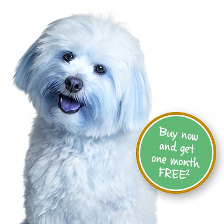

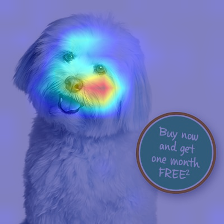

In [0]:
# GradCam on final layer
gradcam(x,dog,layer="block5_conv3")

153


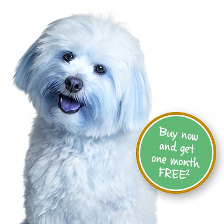

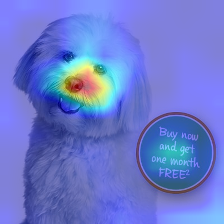

In [0]:
# GradCam on penultimate layer
gradcam(x,dog,layer="block5_conv2")

153


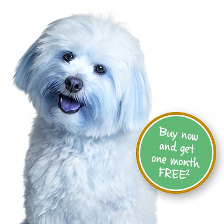

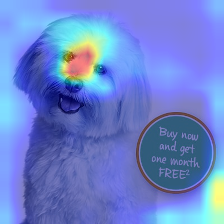

In [0]:
#Layer before that.
gradcam(x,dog,layer="block5_conv1")

**Part 2 : Load RDJ image and spot the sunglasses**

As the link restricts the loading of the image. I have uploaded the image to my drive for ease of access, below code explains the process of connecting to drive and loading the image.

*   After loading the image, repeat the process we did for the previous image.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH_OF_DATA= '/content/gdrive/"My Drive"'
!ls {PATH_OF_DATA}

(1, 224, 224, 3)


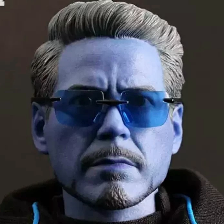

In [0]:
## Display the actual image in console
Image=io.imread('gdrive/My Drive/Image.jpg')
Image = cv2.resize(Image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
y = image.img_to_array(Image)
y = np.expand_dims(y, axis=0)
y = preprocess_input(y)
print(y.shape)
cv2_imshow(Image)

The class id is selected from the Imagenet class tree, ids both 836 and 837 gives us the expected result. 

837


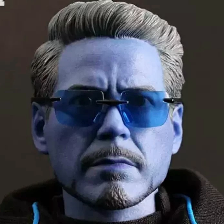

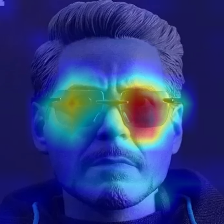

In [0]:
gradcam(y,Image,layer="block5_conv3",id=837)